# EDA of the Stroke Prediction problem

## Reading the data set

First of all, the necessary modules to deal with the problem's data is loaded and the dataset is read. 

In [7]:
# Standard library imports
import os
import sys

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from pathlib import Path

# Inline plotting for Jupyter
%matplotlib inline

# Local application imports
from stroke_predictor.utils.data_io import load_csv_dataset, save_to_hdf
from stroke_predictor.utils.plotting import (
    plot_categorical_counts,
    plot_correlation_heatmap,
    plot_pairwise,
    plot_variable_distributions,
)
from stroke_predictor.utils.preprocessing import (
    drop_rows_with_missing,
    encode_categorical,
    impute_missing_knn,
    replace_missing_to_value,
    split_and_rebuild_dataframe,
)


Read the dataframe from the csv file and display a summary of it.

In [8]:
# Read the dataset from a CSV file and store it in a DataFrame
dataset_path = Path("./data/healthcare-dataset-stroke-data.csv")
df_stroke = load_csv_dataset(dataset_path)

# Display a summary of the dataset
print("Summary of the dataset:")
df_stroke.info()

Summary of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Drop useless features and display first rows of the data set to see if it has been loaded properly.

In [9]:
# The id column is not needed for analysis, so we can drop it
df_stroke.drop(columns=['id'], inplace=True)

# We can also display the first few rows of the dataset to see if it loaded correctly
df_stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


From the previous code snippet, we can see that there are 10 predictive variables (3 float, 2 int, and 5 object types) that need to be transformed to predict the stroke column (an integer indicating yes/no), which defines a binary classification problem. Based on the Non-Null Count column, we also observe that the bmi column has missing values that will need to be imputed.

## Dealing with missing values

From the previous introductory analysis, we saw that, at least, the "bmi" column has NaN values. We can try to see if there is any correlation with other variables to try to infer its value.

We can also check if any of the categorical values has any missing values by their class name.

Value counts for gender:
gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64



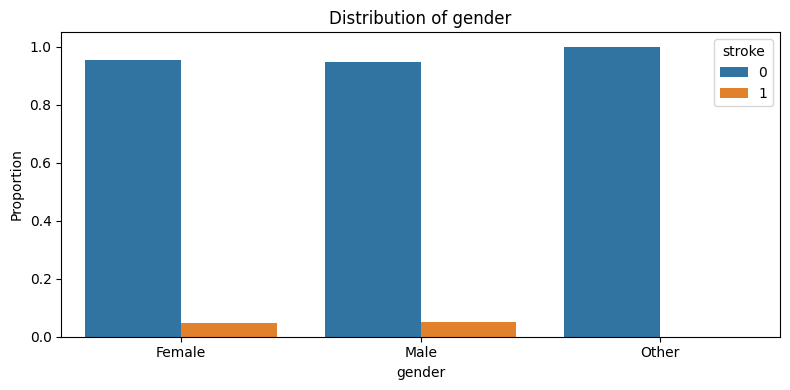

Value counts for ever_married:
ever_married
Yes    3353
No     1757
Name: count, dtype: int64



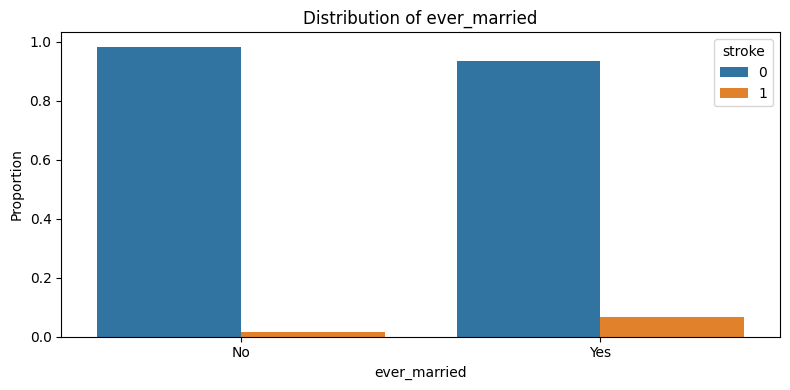

Value counts for work_type:
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64



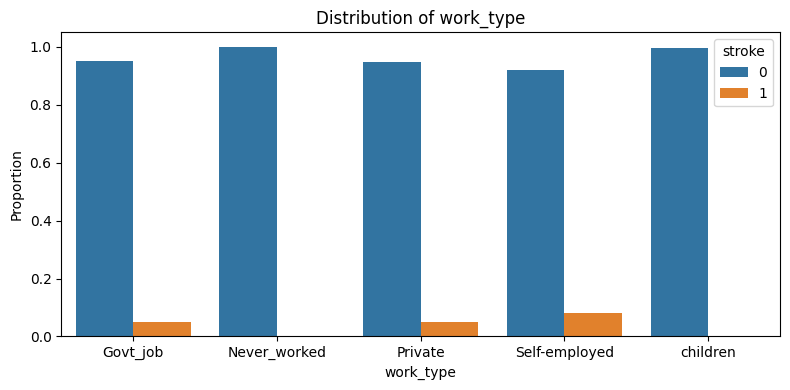

Value counts for Residence_type:
Residence_type
Urban    2596
Rural    2514
Name: count, dtype: int64



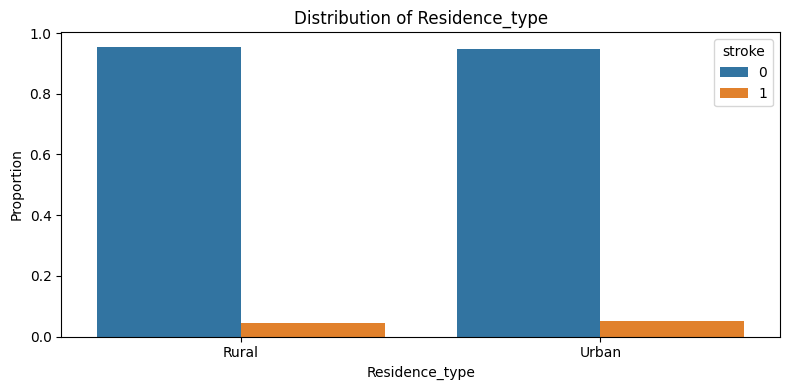

Value counts for smoking_status:
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64



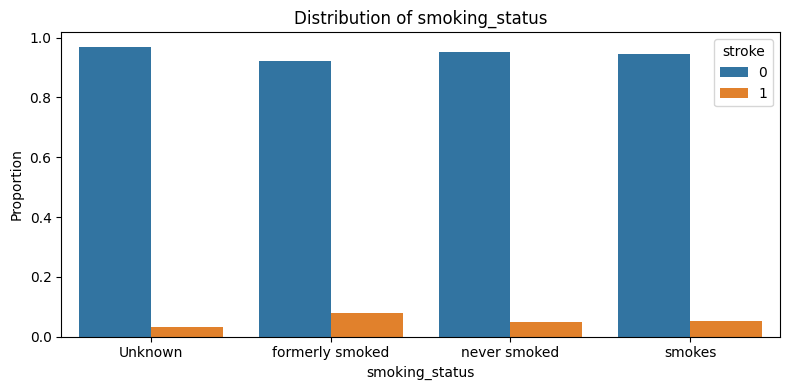

In [10]:
# Display the unique values of the object columns to understand the categorical variables
for col in df_stroke.select_dtypes(include=['object']).columns:
    #print(f"Unique values in {col}: {df_stroke[col].unique()}")
    # Print the unique values and their counts
    print(f"Value counts for {col}:\n{df_stroke[col].value_counts()}\n")
    # Plot the distribution of the categorical variable
    plot_categorical_counts(df=df_stroke, column=col, normalize=True, hue="stroke")

It was observed that both the "gender" and "smoking_status" columns present values with "Other" and "Unknown" values, respectively. For the gender column, a single instance has the "Other" value, we can remove it as it will potentially introduce a bias when training the algorithm. Regarding the smoking status, we can substitute the "Unknown" NaN values before imputing the missing values.

In [11]:
# Change the "Unknown" values in the 'smoking_status' column to NaN
df_stroke = replace_missing_to_value(df=df_stroke, 
                                     column='smoking_status', 
                                     missing_value='Unknown',
                                     new_value=np.nan)

# Remove the event with "Other" value in the 'gender' column 
df_stroke = drop_rows_with_missing(df=df_stroke,
                                   column="gender",
                                   missing_value="Other",)

# Reset the index of the DataFrame after dropping rows
df_stroke.reset_index(drop=True, inplace=True)

Before imputing missing values, they have to be encoded.

In [12]:
# Select only the catergorical columns for encoding
categorical_cols = df_stroke.select_dtypes(include=['object']).columns
df_stroke_encoded, encoder = encode_categorical(df=df_stroke, 
                                             columns=categorical_cols,)
# Drop the 'stroke' column before imputing because it is the target variable and 
# we wouldn't know it
df_stroke_encoded.drop(columns=['stroke'], inplace=True)

# We can print the assigned categories for each categorical column
for col, categories in zip(categorical_cols, encoder.categories_):
    print(f"{col}:")
    for i, cat in enumerate(categories):
        print(f"  {cat} → {i}")


gender:
  Female → 0
  Male → 1
ever_married:
  No → 0
  Yes → 1
work_type:
  Govt_job → 0
  Never_worked → 1
  Private → 2
  Self-employed → 3
  children → 4
Residence_type:
  Rural → 0
  Urban → 1
smoking_status:
  formerly smoked → 0
  never smoked → 1
  smokes → 2
  nan → 3


Now that we have the encoded dataset, we can use it to handle the missing values in the original data set. For this, we can estimate their values according to the one of the closest neighbours using a KNN. 

In [13]:
# Use a KNNImputer to handle missing values in the dataset
df_imputed = impute_missing_knn(df=df_stroke_encoded,
                                columns=df_stroke_encoded.columns,
                                n_neighbors=5)

We can analyse what was done by plotting the original distribution and the new one after correcting the missing values.

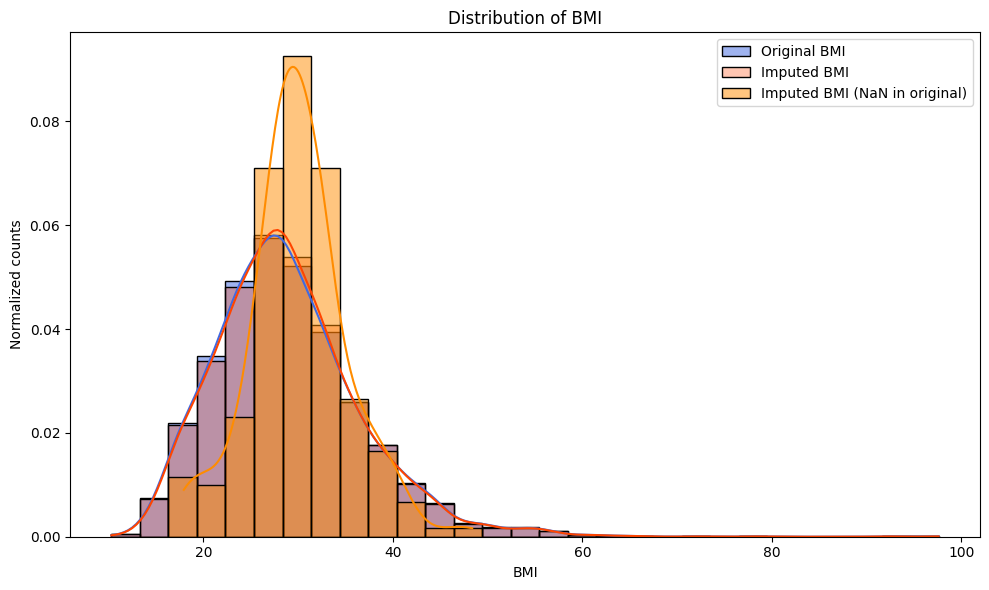

In [14]:
plot_variable_distributions(
    series_list=[
        df_stroke['bmi'],
        df_imputed['bmi'],
        df_imputed['bmi'][df_stroke['bmi'].isna()]
    ],
    labels=['Original BMI', 'Imputed BMI', 'Imputed BMI (NaN in original)'],
    colors=['royalblue', 'orangered', 'darkorange'],
    alpha_list=[0.5, 0.3, 0.5],
    xlabel='BMI',
    title='Distribution of BMI'
)

As it was expected, most of the values were added close to the mean of the data distributions. We can now subtitute this values in the original data set.

In [15]:
# Add the new bmi column to the original DataFrame
df_stroke['bmi'] = df_imputed['bmi']

Now, with the smoking status variable, we can make it categorical again and round the values to the closest class.

In [16]:
# For this column, as it gave continuous values, round to the nearest integer
df_imputed['smoking_status'] = df_imputed['smoking_status'].round().astype(float)

# Change the values for its corresponding categories
df_imputed['smoking_status'] = df_imputed['smoking_status'].replace({0.0: 'formerly smoked', 1.0: 'never smoked', 2.0: 'smokes', 3.0: np.nan})

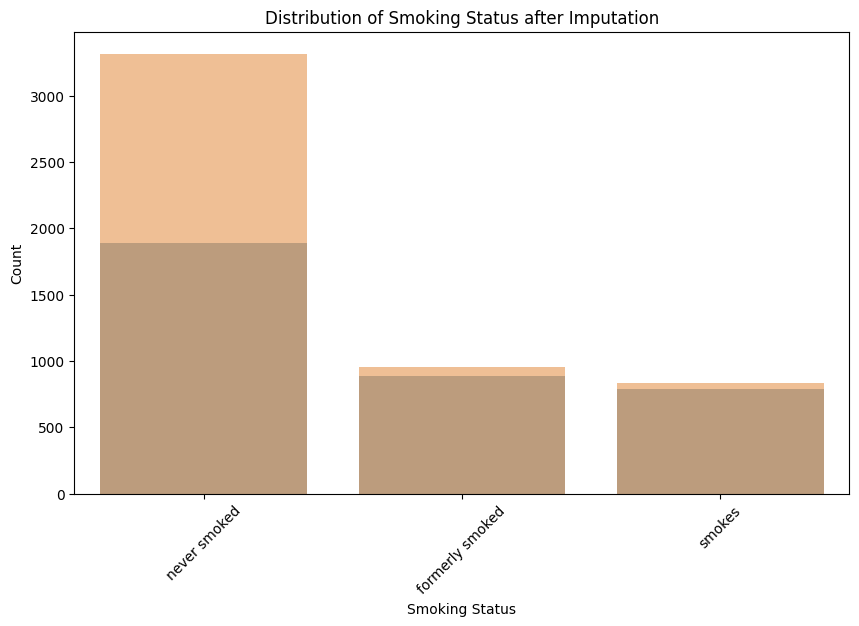

Unique values in smoking_status after imputation:
['formerly smoked' 'never smoked' 'smokes']
[ 0.  1.  2. nan]


In [17]:
# We can also check the smoking status distribution after imputation
plt.figure(figsize=(10, 6))
sns.countplot(data=df_stroke, x='smoking_status', order=df_stroke['smoking_status'].value_counts().index, alpha=0.5)
sns.countplot(data=df_imputed, x='smoking_status', order=df_imputed['smoking_status'].value_counts().index, alpha=0.5)
plt.title('Distribution of Smoking Status after Imputation')
plt.xticks(rotation=45)
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.show()

# Print the unique values of the smoking_status column after imputation
print("Unique values in smoking_status after imputation:")
print(df_imputed['smoking_status'].unique())
print(df_stroke_encoded['smoking_status'].unique())

Since everything looks fine, we can already add the data to the original data set.

In [18]:
# Add the new smoking_status column to the original DataFrame
df_stroke['smoking_status'] = df_imputed['smoking_status']

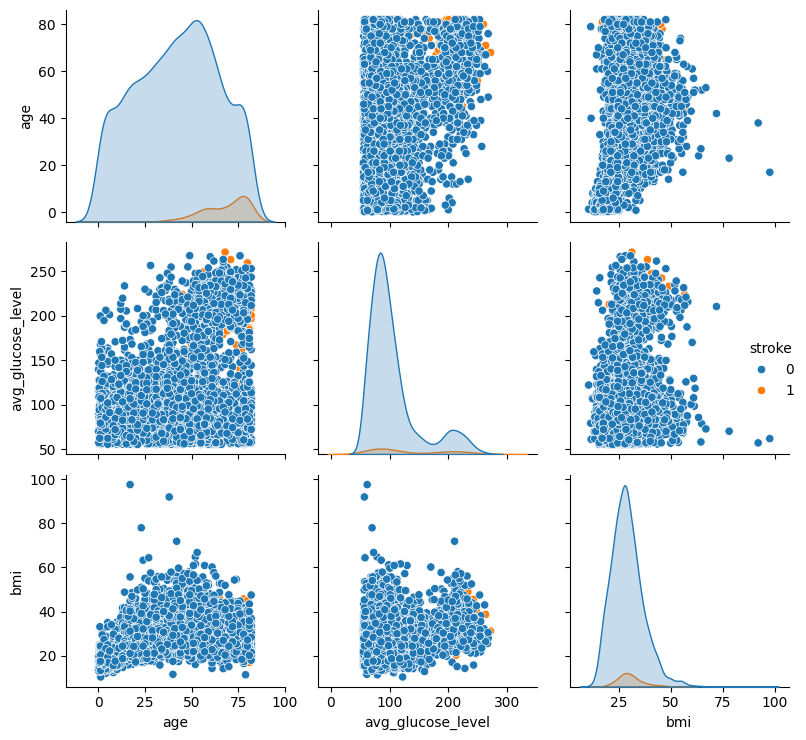

In [19]:
# Filter the DataFrame to have only continuous variables and stroke
df_stroke_continuous = df_stroke.select_dtypes("float64") 
# Add the 'stroke' column to the DataFrame
df_stroke_continuous['stroke'] = df_stroke['stroke']
# Plot pairwise relationships for continuous variables
plot_pairwise(df_stroke_continuous, hue='stroke', height=2.5);


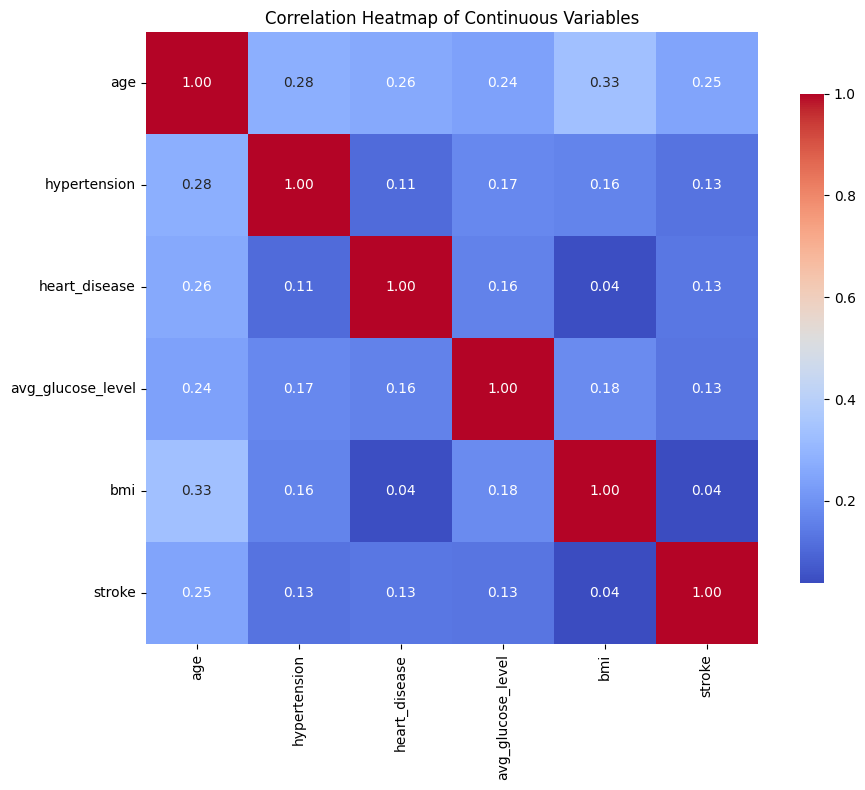

In [20]:
# Create heatmap to visualize the correlation between continuous variables
corr_matrix = plot_correlation_heatmap(df_stroke)


Now we can check if the classes are balanced or if we need to balance them before the training.

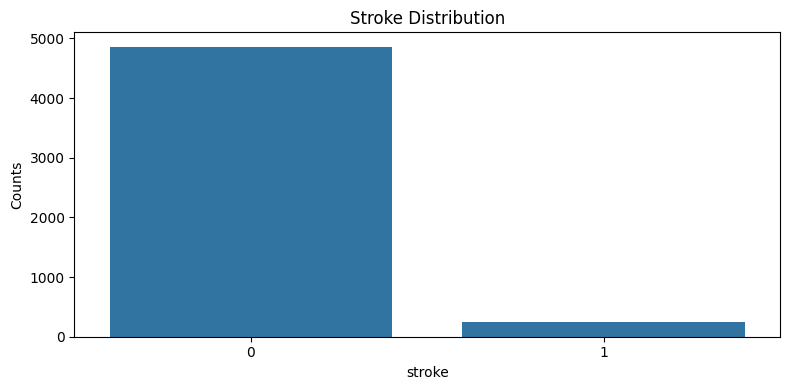

Stroke distribution:
stroke
0    0.951262
1    0.048738
Name: proportion, dtype: float64



In [21]:
# Make histogram to see if the stroke column is imbalanced
plot_categorical_counts(df=df_stroke, 
                         column='stroke', 
                         normalize=False, 
                         hue=None, 
                         title='Stroke Distribution')

print(f"Stroke distribution:\n{df_stroke['stroke'].value_counts(normalize=True)}\n")

The dataset is highly imbalanced in a proportion of 95% to 5%, so we need to balance it before training.

## Engineered variables

Now that the missing values have been imputed, new variables can be created to try to help in the classification tasks.

We can distribute the samples in categories of the BMI, as classified by the World Health Organization. This information should be useful, as obesity brings a potential risk of suffering stroke.

In [22]:
# We can set groups of the bmi 
df_stroke['bmi_category'] = pd.cut(df_stroke['bmi'], bins=[0, 18.5, 25, 30, 100], 
                            labels=['underweight', 'normal', 'overweight', 'obese'])


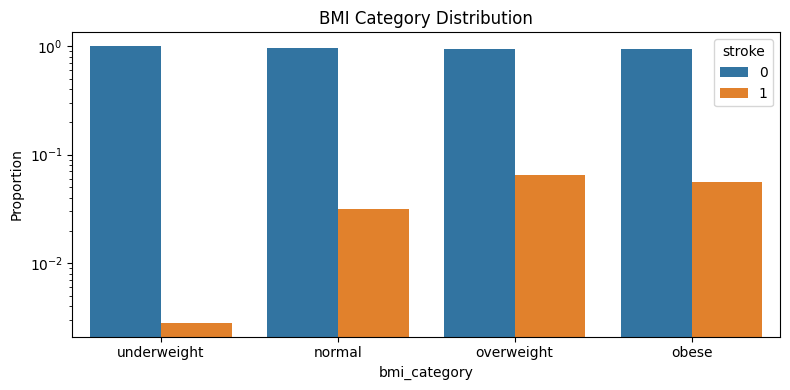

In [23]:
# See the correlation between the bmi_category and stroke
plot_categorical_counts(df=df_stroke, 
                         column='bmi_category', 
                         normalize=True, 
                         hue='stroke', 
                         title='BMI Category Distribution',
                         y_log=True)


It can be seen that, when increasing the BMI category, a higher risk of stroke is found. This should help in the classification.

We can also classify the patients in age ranges, as older people is more likely to suffer stroke.

In [24]:
df_stroke['age_group'] = pd.cut(df_stroke['age'], bins=[0, 30, 45, 60, 75, 100], 
                        labels=['young', 'adult', 'middle_aged', 'senior', 'elderly'])

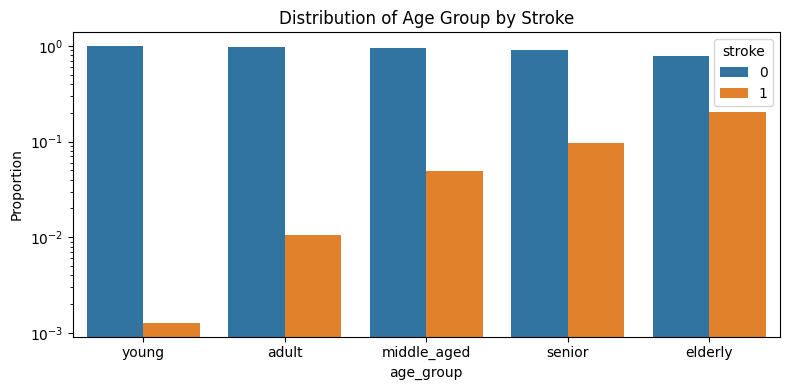

In [25]:
# See the correlation between the age_group and stroke
plot_categorical_counts(df=df_stroke, 
                         column='age_group', 
                         normalize=True, 
                         hue='stroke', 
                         title='Distribution of Age Group by Stroke',
                         y_log=True)

We can see, once again, that this engineered variable should help for classification, showing that older people have a higher risk of suffering the disease as expected.

Another variable can be created regarding the level of glucose in blood, which also supposes a potential health risk.

In [26]:
df_stroke['glucose_category'] = pd.cut(df_stroke['avg_glucose_level'], 
                                bins=[0, 99, 125, 300], 
                                labels=['normal', 'prediabetic', 'diabetic'])

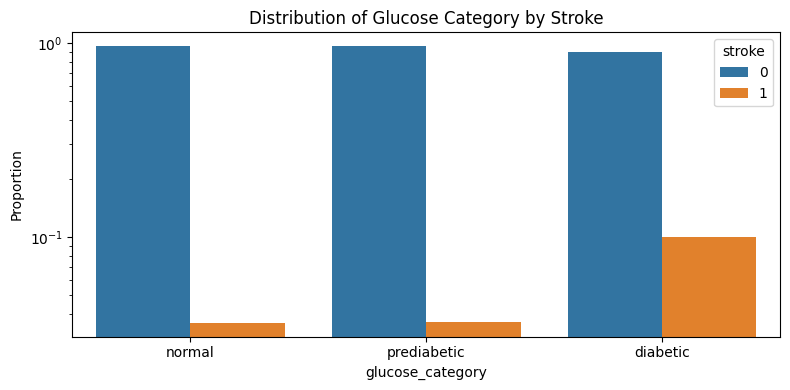

In [27]:
# See the correlation between the glucose_category and stroke
plot_categorical_counts(df=df_stroke, 
                         column='glucose_category', 
                         normalize=True, 
                         hue='stroke', 
                         title='Distribution of Glucose Category by Stroke',
                         y_log=True)

Finally, we can create a health issue category aggregating all this, being positive when the age is >60, is diabetic, smokes, has hypertension and a heart disease. 

In [28]:
def compute_health_score(row):
    score = 0
    score += int(row['age'] > 60)
    score += int(row['avg_glucose_level'] >= 200)
    score += int(row['smoking_status'] == 'smokes')
    score += int(row['hypertension'] == 1)
    score += int(row['heart_disease'] == 1)
    return score

df_stroke['health_score'] = df_stroke.apply(compute_health_score, axis=1)

# Optional: categorize score into risk levels
def categorize_risk(score):
    if score <= 1:
        return 'low risk'
    elif score <= 3:
        return 'moderate risk'
    else:
        return 'high risk'

df_stroke['risk_category'] = df_stroke['health_score'].apply(categorize_risk)


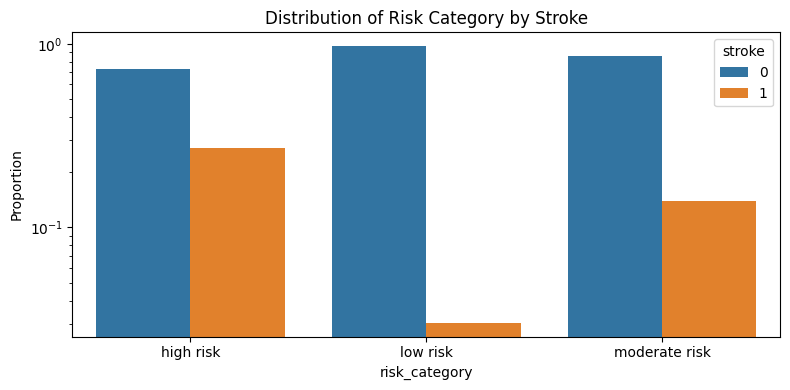

In [29]:
# See the correlation between the risk_category and stroke
plot_categorical_counts(df=df_stroke, 
                         column='risk_category', 
                         normalize=True, 
                         hue='stroke', 
                         title='Distribution of Risk Category by Stroke',
                         y_log=True)


## Saving data

Finally, the data set can be saved and we can split it in train/test. Since the target variable is not balanced, it is really important to do a stratified splitting.

In [30]:
# Split data
df_train, df_test = split_and_rebuild_dataframe(df=df_stroke, 
                                                target_column='stroke', 
                                                test_size=0.3, 
                                                random_state=42, 
                                                stratify=True)

# Display the shape of the training and test sets
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
# Display the distribution of the target variable in both sets
print(f"Training set stroke distribution:\n{df_train['stroke'].value_counts(normalize=True)}\n")
print(f"Test set stroke distribution:\n{df_test['stroke'].value_counts(normalize=True)}\n")




Training set shape: (3576, 16)
Test set shape: (1533, 16)
Training set stroke distribution:
stroke
0    0.951342
1    0.048658
Name: proportion, dtype: float64

Test set stroke distribution:
stroke
0    0.951076
1    0.048924
Name: proportion, dtype: float64



Save the data.

In [32]:
# Save to a single HDF5 file with keys 'Train' and 'Test'
save_to_hdf(df=df_train, path=Path('./data/stroke_data.h5'), key='Train', mode='w')
save_to_hdf(df=df_test, path=Path('./data/stroke_data.h5'), key='Test', mode='a')